In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import Levenshtein as Lv
%matplotlib inline

Load all names from the file
Create Dictionary to convert a character into an integer relating to the position of the character in the orderedAlphabet

In [123]:
# Read names from file
names = open("names.dat", "r").readlines()
nameCount = len(names)
for i in range(nameCount):
    names[i] = names[i].removesuffix("\n")

In [124]:
# Creates sorted alphabet
orderedAlphabet = list(string.ascii_lowercase + "ä" + "ö" + "ü" + "-")
alphabetLength = orderedAlphabet.__len__()

In [125]:
#Creates dictionary to convert character to index
lettertoindex = {}
for key, value in zip(orderedAlphabet, range(alphabetLength)):
    lettertoindex[key] = value
lettertoindex

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 'ä': 26,
 'ö': 27,
 'ü': 28,
 '-': 29}

### Interpretation 1:
##### Evaluate every word combination and dismiss all word combinations that have a bigger Levenshtein distance than 1. Look up which letter vary in a word combination and count up every possible letter variation. Create a heatmap based on the counts of each letter combination

Initialise the NumPy-Array to store the likelyhood of occurence of each possible letter combination in the alphabet.

In [126]:
heatmap = np.zeros((alphabetLength, alphabetLength), dtype=float)

Iterate over every possible pairing of firstnames. Calculate the Levenshtein distance using the Levenshtein library and distance() and dismiss every word combination bigger than 1.
Count up all occuring letter variations using the editops() Function. 
The order of occurence of the characters in the tuple should also play no role. The following letter variation ```('a','b')``` should count towards the letter variations ```ab``` and ```ba```.



In [127]:
for i in range(nameCount):
    for j in range(i+1, nameCount):
        a = names[i]
        b = names[j]
        if(Lv.distance(a, b)!=1):
            continue
        variations = Lv.editops(a,b)
        for variation in variations:
            if variation[0] == 'delete' or variation[0] == 'insert':
                continue
            heatmap[lettertoindex[a[variation[1]]], lettertoindex[b[variation[2]]]] += 1
            heatmap[lettertoindex[b[variation[2]]], lettertoindex[a[variation[1]]]] += 1

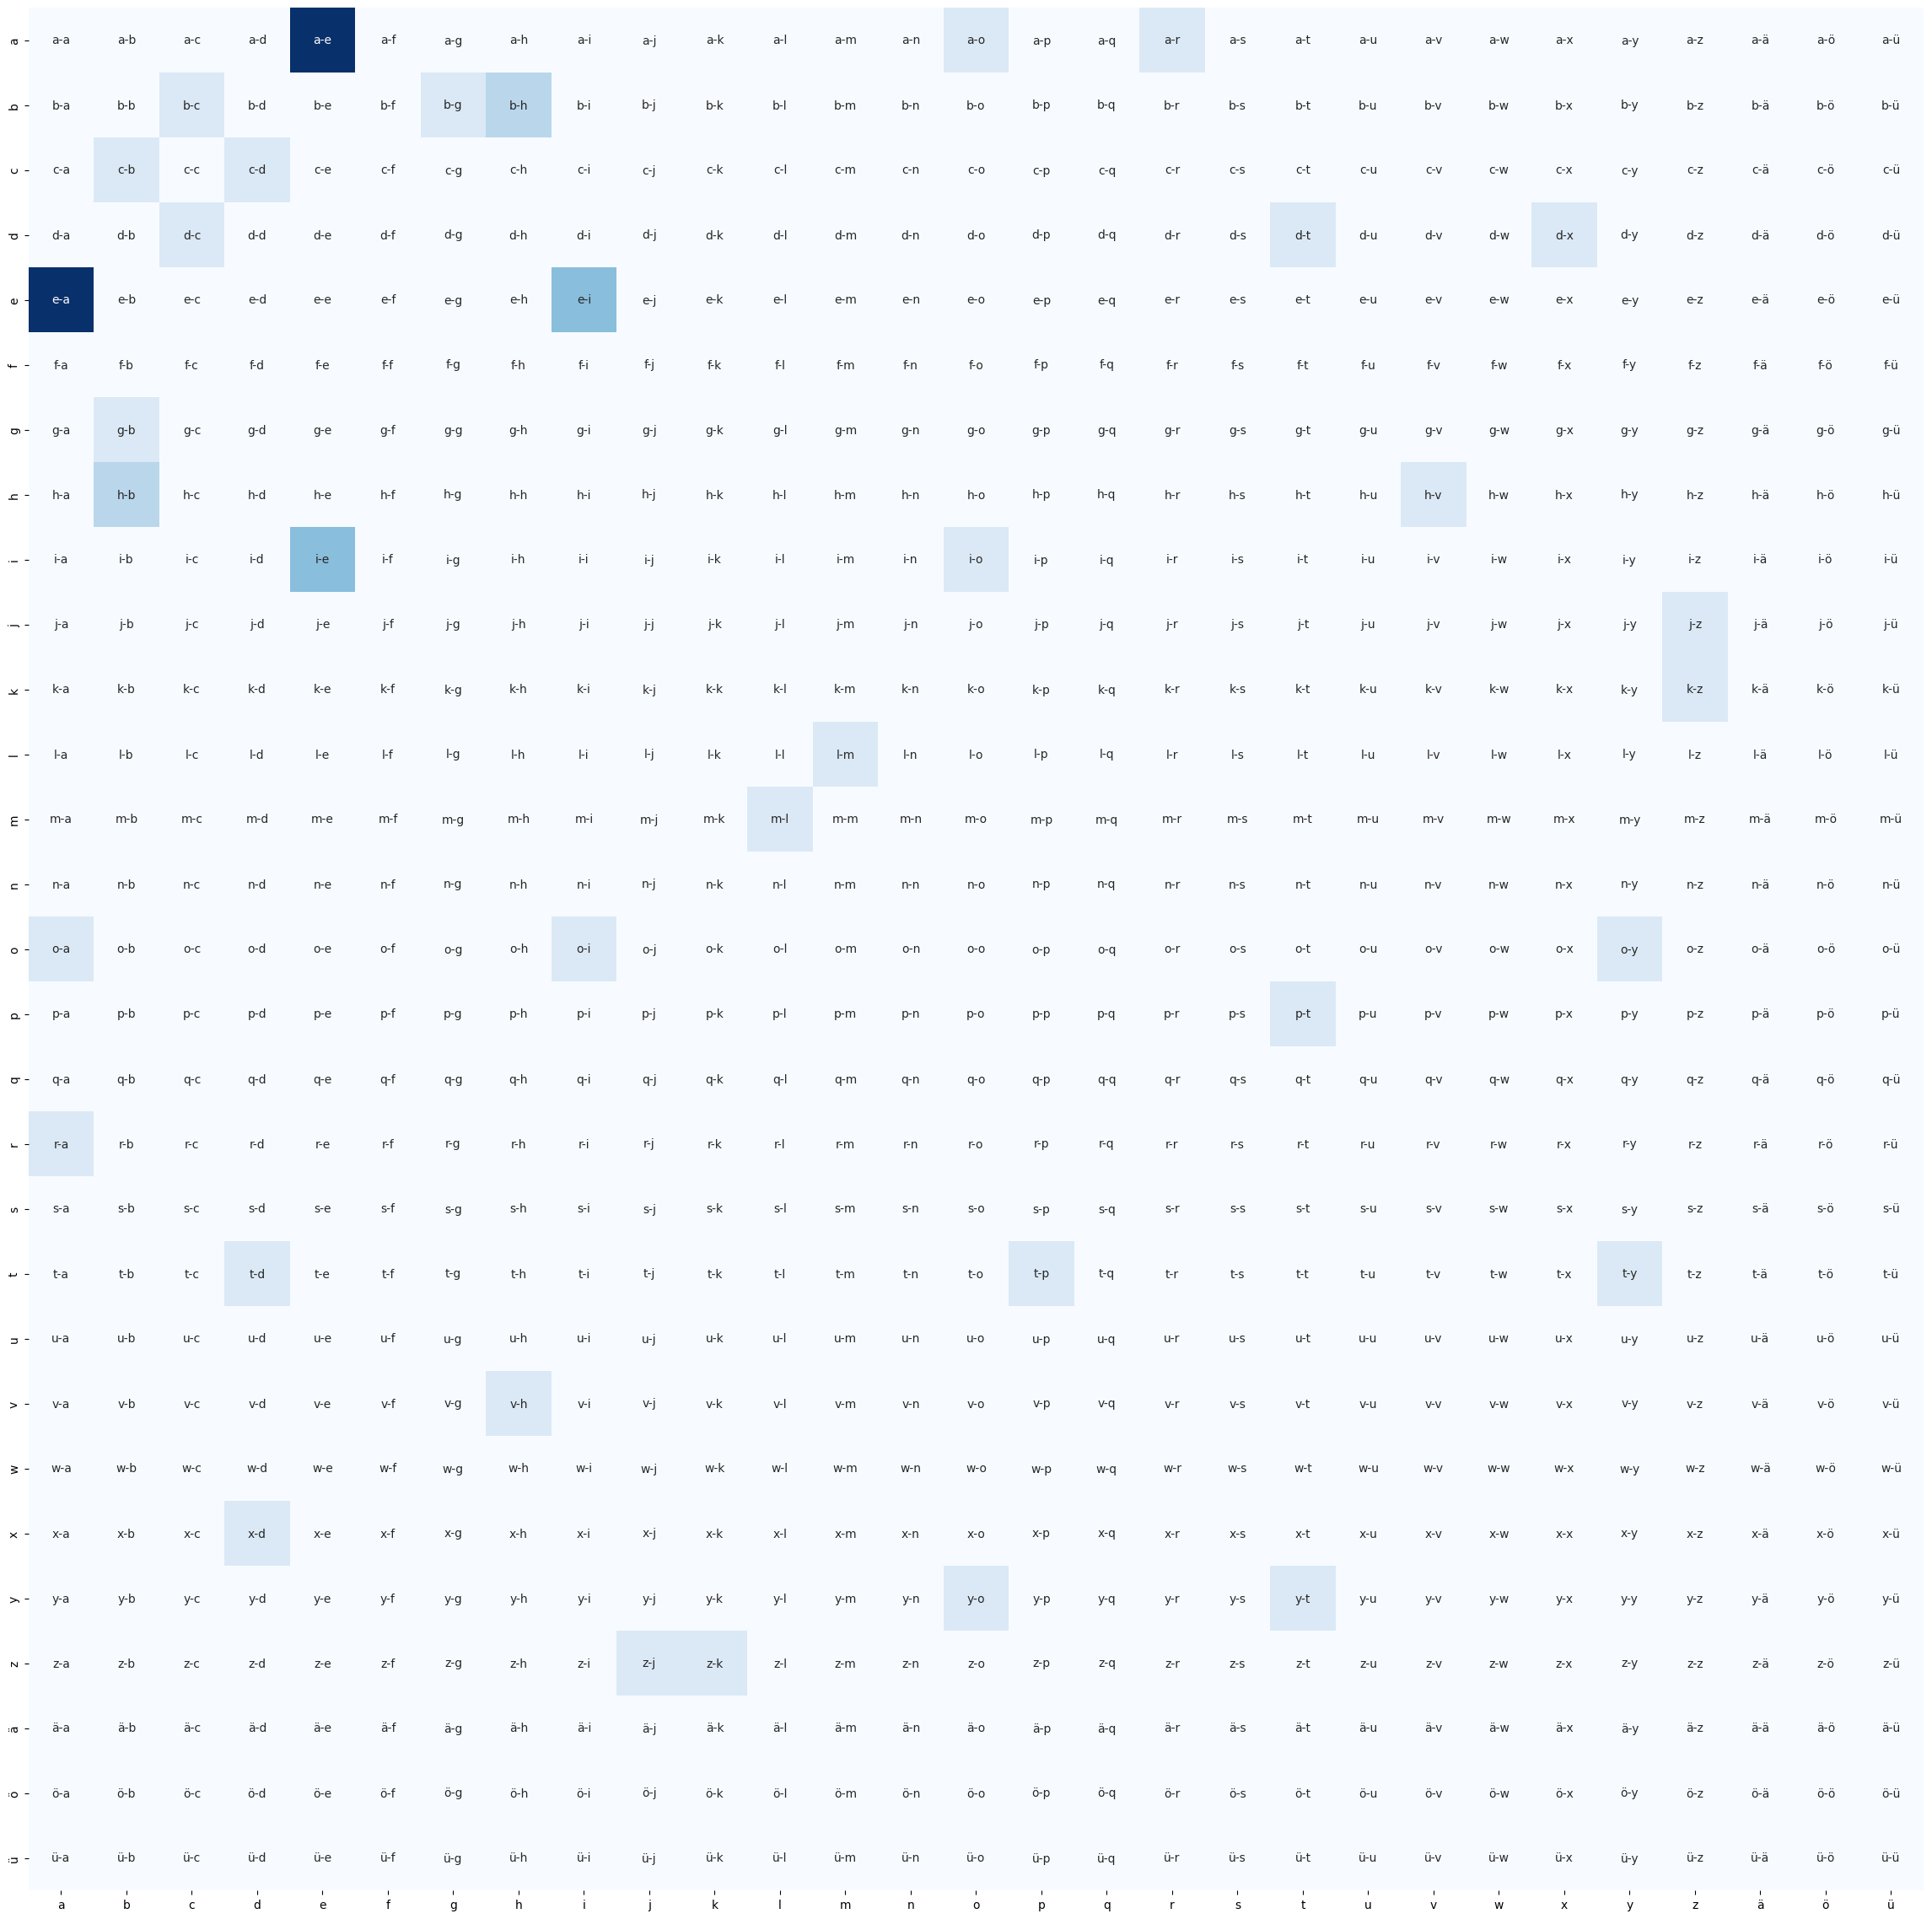

In [128]:
# display the heatmap using matplotlib and seaborn
annot = np.array(
    [str(x + "-" + y) for x in orderedAlphabet[:-1] for y in orderedAlphabet[:-1]]).reshape(alphabetLength-1, alphabetLength-1)
heatmap = np.delete(heatmap, 29, 0)
heatmap = np.delete(heatmap, 29, 1)
plt.figure(figsize=(alphabetLength-1, alphabetLength-1))
sns.heatmap(heatmap, cmap="Blues", fmt="s", annot=annot, cbar=False,
            xticklabels=orderedAlphabet[:-1], yticklabels=orderedAlphabet[:-1])

plt.show()

### Interpretation 2:
##### Use Levenshtein Matrix to traverse through it recursively and find all possible optimal paths. Weight all possible letter variations relative to the depth of the branches and relative to the Levenshtein distance

Algorithm to calculate Levenshtein distance and create a numpy matrix. In a ```m x n```-matrix, the Levenshtein distance  is at the position ```m, n```.

In [129]:
def lev(a, b):
  row, col = len(a), len(b)
  matrix = np.zeros((row + 1, col + 1), dtype=int) # matrix to store levenshtein matrix
  for i in range(0, row + 1):
    matrix[i][0] = i
  for j in range(0, col + 1):
    matrix[0][j] = j
  for i in range(1, row + 1):
    for j in range(1, col + 1):
      # delta is 1 if mismatch of characters
      delta = int(a[i-1] != b[j-1])
      matrix[i][j] = min(matrix[i-1][j] + 1,
                      matrix[i][j-1] + 1,
                      matrix[i-1][j-1] + delta)
  return(matrix)

lev("peter", "petra")

array([[0, 1, 2, 3, 4, 5],
       [1, 0, 1, 2, 3, 4],
       [2, 1, 0, 1, 2, 3],
       [3, 2, 1, 0, 1, 2],
       [4, 3, 2, 1, 1, 2],
       [5, 4, 3, 2, 1, 2]])

Algorithm for traversing the matrix and finding the path. The possible paths are stored in a list of tuples.  
Recursively calls itself for every possible path. Stores the depth of the branch in the tuple

In [130]:
def minCount(a, b, c, branches):
  minimum = min(a, b, c)
  i = [a,b,c].count(minimum)
  return minimum, branches * i

def findChange(matrix: np.array, changes: list, a, b, indexA, indexB, branches) -> list:
    # if the end of the matrix is reached, return
    if indexA == -1 or indexB == -1:
        return changes
    
    # find the minimum value in the matrix
    minimum, branchCount = minCount(matrix[indexA-1][indexB-1], matrix[indexA-1][indexB], matrix[indexA][indexB-1], branches)

    # if the letters of the words a and b on indexA and indexB are the same, check if the minimum is the diagonal value and call the function only on the diagonal
    # otherwise proceed to call all possible paths recursively
    if a[indexA-1] == b[indexB-1] and (minimum == matrix[indexA-1][indexB-1]):
      (findChange(matrix, changes, a, b, indexA - 1, indexB - 1, branches))
      return changes

    else:
      if(minimum == matrix[indexA-1][indexB-1]):
        changes.append((a[indexA-1], b[indexB-1], branchCount))
        (findChange(matrix, changes, a, b, indexA - 1, indexB - 1, branchCount))
      if(minimum == matrix[indexA-1][indexB]):
        changes.append(('-', a[indexA-1], branchCount))
        (findChange(matrix, changes, a, b, indexA - 1, indexB, branchCount))
      if(minimum == matrix[indexA][indexB-1]):
        changes.append(('-', b[indexB-1], branchCount))
        (findChange(matrix, changes, a, b, indexA, indexB - 1, branchCount))
    return changes
    
a = "peter"
b = "petra"
change = []
findChange(lev(a,b), change, a, b, len(a)-1, len(b)-1, 1)
change


[('e', 'r', 1), ('r', 'a', 1)]

Initialise the NumPy-Array to store the likelyhood of occurence of each possible letter combination of characters in the alphabet.

In [131]:
heatmap = np.zeros((alphabetLength, alphabetLength), dtype=float)

Iterate over every possible pairing of firstnames. Create the Levenshtein-matrix of each pair and traverse it using the findChange algorithm.
An edge is represented as a 3 element tuple ```(a, b, branchCount)```, ```a``` and ```b``` are the characters that are vary.
Every combination of characters represented by an edge is then inserted into the heatmap. The value is weighted relative to the depth of the branch and the Levenshtein-distance. The levenshtein distance is squared to devalue all character variations from word combinations that are dissimilar. The letter variations in ```Anne``` and ```Anna``` should be valued stronger than the letter variations of ```Michael``` and ```Patrick```.  
The order of occurence of the characters in the tuple should also play no role. The following edge ```('a','b',1)``` should count towards the letter variations ```ab``` and ```ba```.



In [132]:
for i in range(nameCount):
    for j in range(i+1, nameCount):
        a = names[i]
        b = names[j]
        matrix  = (lev(b, a))
        levdistance = matrix[len(b), len(a)]
        lettervariations = findChange(matrix, [], b, a, len(b), len(a), 1)
        for change in lettervariations:
            heatmap[lettertoindex[change[0]], lettertoindex[change[1]]] += (1/change[2])/(levdistance**2)
            heatmap[lettertoindex[change[1]], lettertoindex[change[0]]] += (1/change[2])/(levdistance**2)

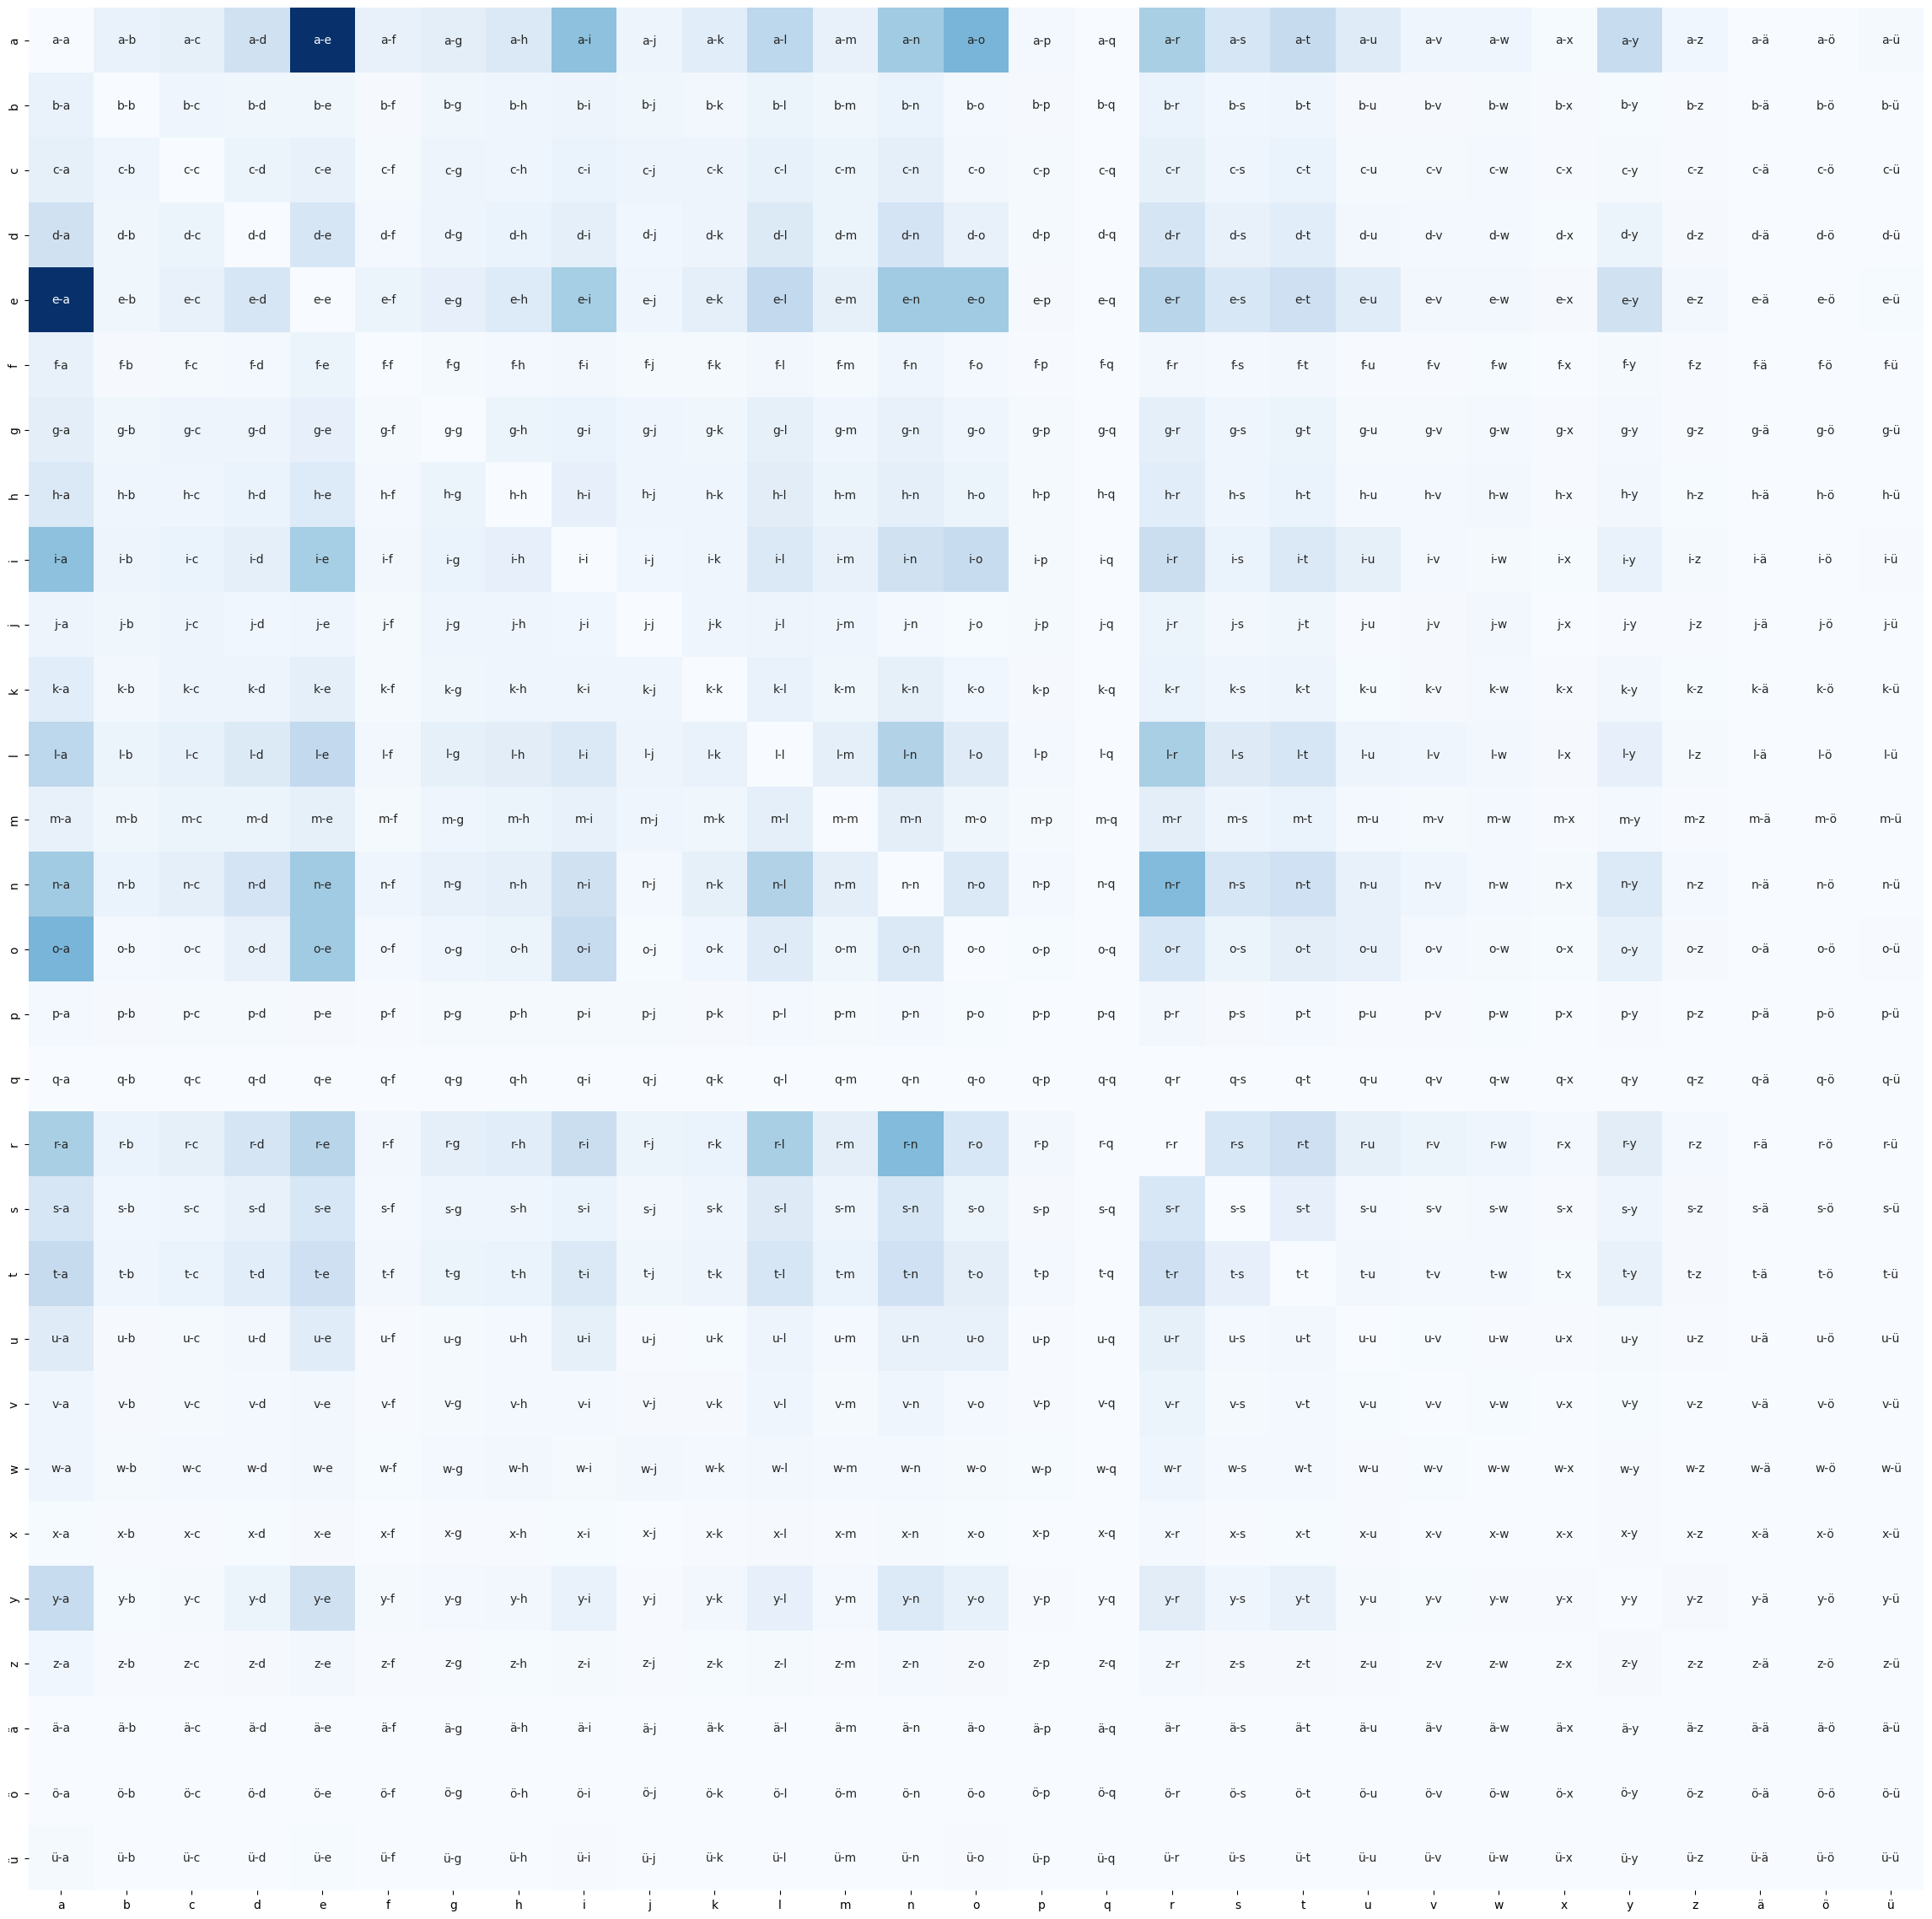

In [133]:
# display the heatmap using matplotlib and seaborn
annot = np.array(
    [str(x + "-" + y) for x in orderedAlphabet[:-1] for y in orderedAlphabet[:-1]]).reshape(alphabetLength-1, alphabetLength-1)
heatmap = np.delete(heatmap, 29, 0)
heatmap = np.delete(heatmap, 29, 1)
plt.figure(figsize=(alphabetLength-1, alphabetLength-1))
sns.heatmap(heatmap, cmap="Blues", fmt="s", annot=annot, cbar=False,
            xticklabels=orderedAlphabet[:-1], yticklabels=orderedAlphabet[:-1])

plt.show()